In [1]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from wandb.keras import WandbMetricsLogger
import resnets as rn

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Set hyperparameters

In [3]:
train_path = "face-mask-12k-images-dataset/Face Mask Dataset/Train"
test_path = "face-mask-12k-images-dataset/Face Mask Dataset/Test"
val_path = "face-mask-12k-images-dataset/Face Mask Dataset/Validation"

image_size = 96
channels = 3
color_mode = "rgb"
validation_split = 0.2
seed = 27

config = {
    "batch_size": 64,
    "epochs": 100,
    "learning_rate": 0.00001,
    "early_stop_patience": 10
}

## Run the following block on Kaggle only!

In [4]:
train_path = "/kaggle/input/" + train_path
test_path = "/kaggle/input/" + test_path
val_path = "/kaggle/input/" + val_path

## Get class names

In [5]:
classes = next(os.walk(train_path))[1]
print(classes)

['WithoutMask', 'WithMask']


## Create training, validation and test datasets

In [6]:
train = image_dataset_from_directory(
    directory=train_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size)
)

validation = image_dataset_from_directory(
    directory=val_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size)
)

test = image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    shuffle=False
)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


## Training on ResNet-18

In [7]:
wandb.init(config=config, project='resnet-different-dataset')

optimizer = Adam(
    learning_rate=config["learning_rate"]
)

loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet18(
    (image_size, image_size, channels),
    include_top=False,
    normalize=True,
    flatten=True,
    dropout_rate=0.2
)

top = Dense(4096, activation='relu')(model.output)
top = Dropout(0.5)(top)
top = Dense(4096, activation='relu')(top)
top = Dropout(0.5)(top)
top = Dense(len(classes), activation='softmax')(top)

model = Model(inputs=model.input, outputs=top)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

callbacks = [
    early_stopping,
    WandbMetricsLogger()
]

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


In [8]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)

Epoch 1/100
157/157 [==============================] - 51s 179ms/step - loss: 0.4661 - sparse_categorical_accuracy: 0.8265 - val_loss: 0.2660 - val_sparse_categorical_accuracy: 0.9013
Epoch 2/100
157/157 [==============================] - 14s 86ms/step - loss: 0.2045 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.1886 - val_sparse_categorical_accuracy: 0.9388
Epoch 3/100
157/157 [==============================] - 14s 85ms/step - loss: 0.1436 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.1027 - val_sparse_categorical_accuracy: 0.9675
Epoch 4/100
157/157 [==============================] - 14s 87ms/step - loss: 0.0958 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.0701 - val_sparse_categorical_accuracy: 0.9800
Epoch 5/100
157/157 [==============================] - 13s 83ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.0824 - val_sparse_categorical_accuracy: 0.9787
Epoch 6/100
157/157 [==============================] - 14s 87ms/step - loss: 0.0515 

In [9]:
wandb.finish()

epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▅▆▇▇▇█████████████
epoch/val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂
epoch/val_sparse_categorical_accuracy,▁▄▆▇▇▇███████▇█████
epoch/epoch,18
epoch/learning_rate,1e-05
epoch/loss,0.00225
epoch/sparse_categorical_accuracy,0.9992
epoch/val_loss,0.07161


## Plotting training progress

<AxesSubplot:>

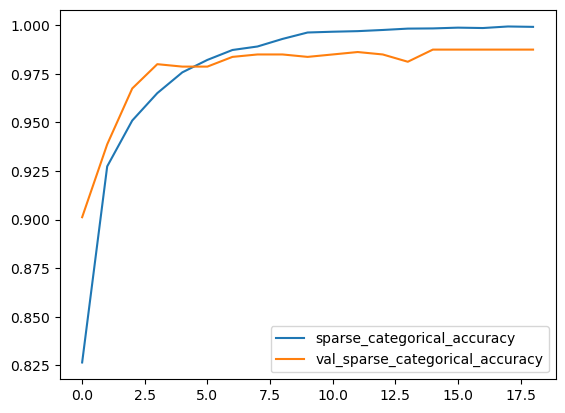

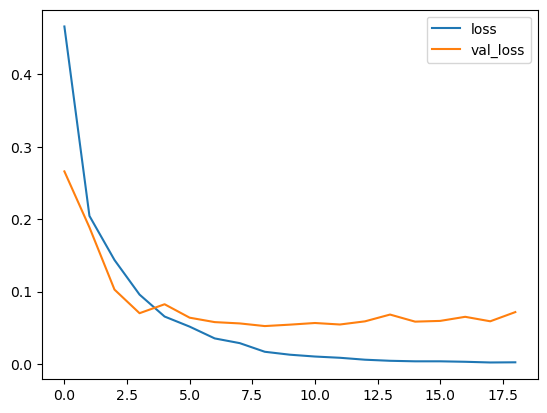

In [10]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

## Predict

In [11]:
y_true_tmp = []
y_pred_tmp = []

for x_test_batch, y_test_batch in test:
    y_true_tmp.append(y_test_batch)
    predictions = model.predict(x_test_batch, verbose=0)
    y_pred_tmp.append(np.argmax(predictions, axis=1))
    
y_true = tf.concat(y_true_tmp, axis=0)
y_pred = tf.concat(y_pred_tmp, axis=0)

## Classification report

In [12]:
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

              precision    recall  f1-score   support

 WithoutMask     0.9784    0.9804    0.9794       509
    WithMask     0.9793    0.9772    0.9782       483

    accuracy                         0.9788       992
   macro avg     0.9788    0.9788    0.9788       992
weighted avg     0.9788    0.9788    0.9788       992



## Confusion matrix

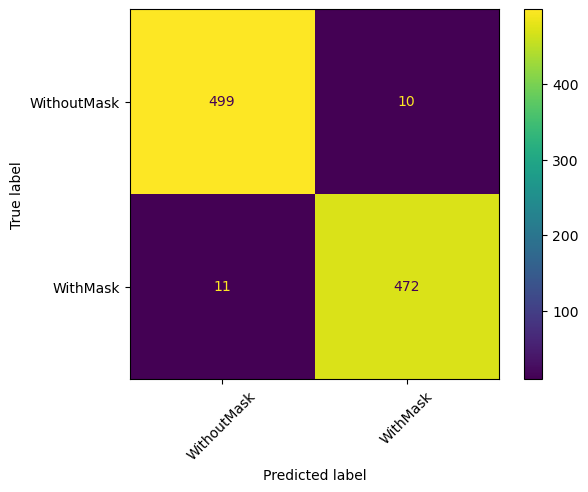

In [13]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes, xticks_rotation=45)